In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from utils import *

Part 1: Create a reasonable state space of the given system

In [2]:
# load the dataset and visualize the 9 columns
raw_data = pd.read_csv("../data/MI_timesteps.txt", sep=" ", index_col=0)

data = np.array(raw_data)

data


array([[36,  0,  0, ...,  0,  0,  0],
       [36,  0,  0, ...,  0,  0,  0],
       [43,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 10, 93, ...,  2,  1, 40],
       [ 0, 10, 93, ...,  3,  1, 41],
       [ 0, 11, 91, ...,  1,  0, 42]], dtype=int64)

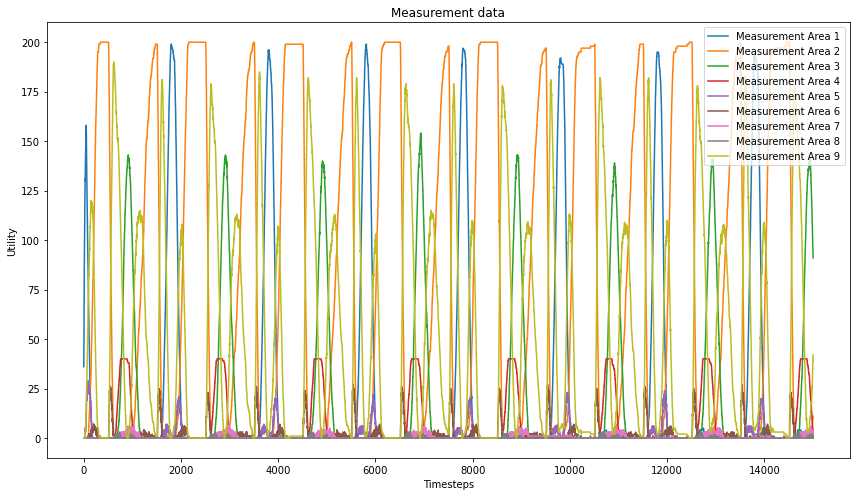

In [19]:
# create a plot
plt.figure(figsize=(12, 7))

for i in range(1, 10):
    plt.plot(data[:, 0], data[:, i], label=f'Measurement Area {i}')

# add titles
plt.title('Measurement data')
plt.xlabel('Timesteps')
plt.ylabel('Utility')

# add legend
plt.legend()

# show plot
plt.tight_layout()
plt.show()

In [4]:
# we take the raw after 1000
data_after1000 = data[1000:]

# then we take the first three column
data_simplified = data_after1000[:, :4]

data_simplified

array([[ 1001,     0,     2,    97],
       [ 1002,     0,     2,    96],
       [ 1003,     0,     2,    95],
       ...,
       [14999,     0,    10,    93],
       [15000,     0,    10,    93],
       [15001,     0,    11,    91]], dtype=int64)

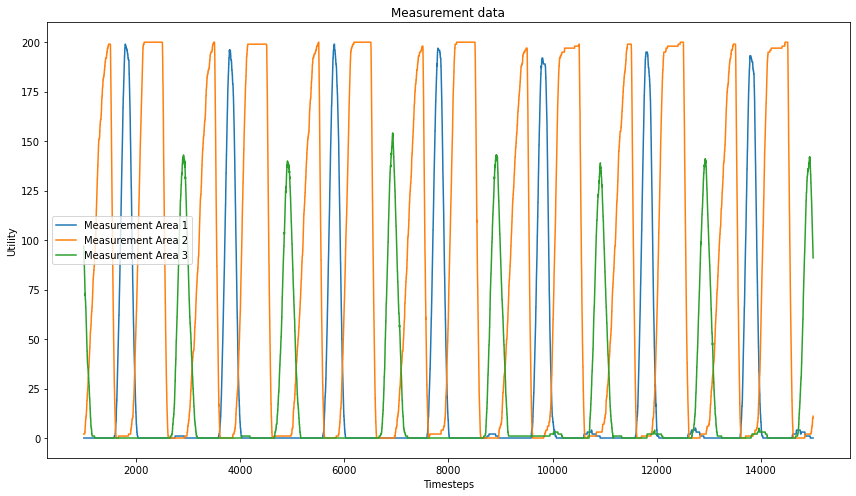

In [20]:
# create a plot
plt.figure(figsize=(12, 7))

for i in range(1, 4):
    plt.plot(data_simplified[:, 0], data_simplified[:, i], label=f'Measurement Area {i}')

# add titles
plt.title('Measurement data')
plt.xlabel('Timesteps')
plt.ylabel('Utility')

# add legend
plt.legend()

# show plot
plt.tight_layout()
plt.show()

In [6]:
# create M times windows
time_delay = 351

M = data_simplified.shape[0] - time_delay

# create Windows_M
windows_M = np.empty((M, 3*time_delay))
for i in range(M):
    windows_M[i] = data[i:i+time_delay, 1:4].flatten()

windows_M.shape

(13650, 1053)

In [7]:
# # figure out the best value of PCA, we want the percentage to be at least 85%
# pca = PCA(n_components = 0.85)
# pc = pca.fit(windows_M)
#
# cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# n_components = np.argmax(cumulative_variance_ratio >= 0.85) + 1
#
# print('principal components is', n_components)

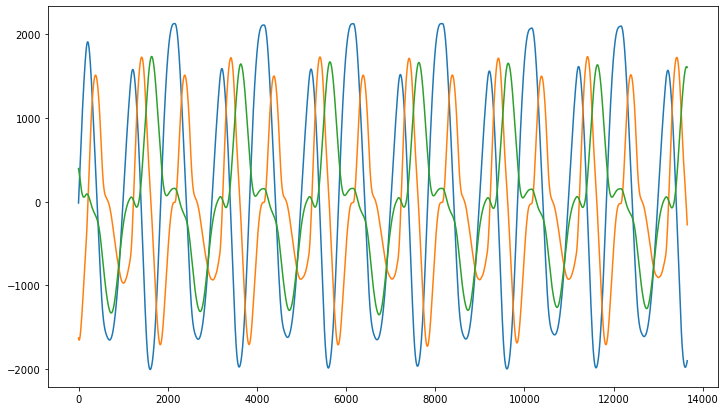

In [21]:
pca = PCA(n_components = 3)
pc = pca.fit(windows_M)
pca_windows = pc.transform(windows_M)

plt.figure(figsize=(12, 7))
for i in range(pca_windows.shape[1]):
    plt.plot(pca_windows[:,i])

Part 2: Color the points by all measurements

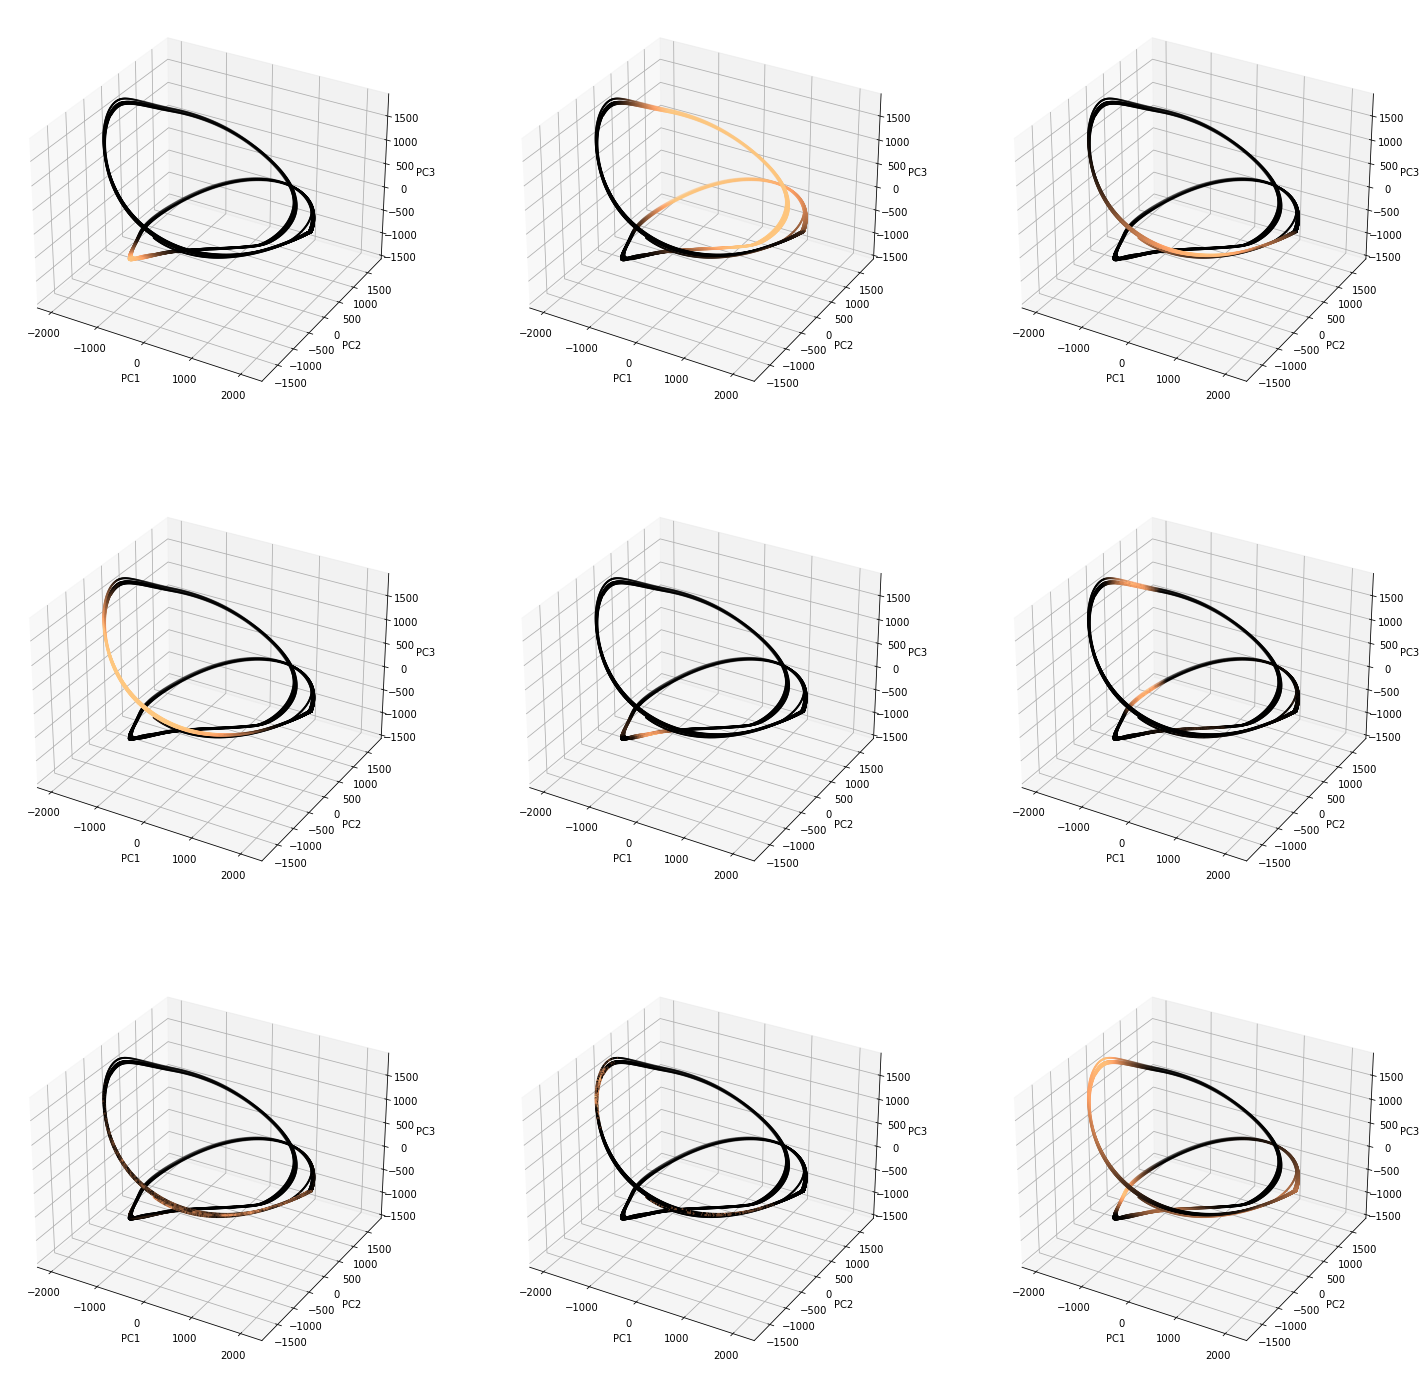

In [9]:
# plot the 3 PCAs in 3d space (9 plots in total)
fig = plt.figure(figsize=(25,25))
for i in range(1,10):
    ax = fig.add_subplot(3, 3, i, projection='3d')
    scatter = ax.scatter(*pca_windows.T, s=1, c=data_after1000[:13650, i], cmap=plt.cm.copper)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
plt.show()


Part 3: learn the dynamics on the curve embedded in the principal components

In [10]:
pca_windows

array([[  -16.682231  , -1630.02717976,   394.53164397],
       [   -3.85375475, -1633.70522607,   392.34301113],
       [    8.98822172, -1637.25905296,   390.14686763],
       ...,
       [-1908.91950616,  -255.15818397,  1606.07072825],
       [-1905.48330201,  -266.0060509 ,  1604.98524922],
       [-1901.94163581,  -276.90908967,  1603.81333241]])

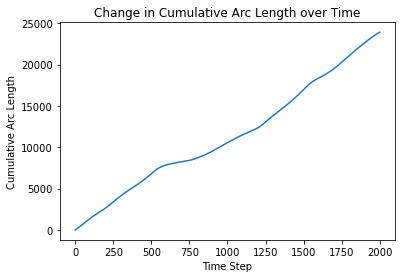

In [11]:
arclens = []  # save arclens at every time
speeds_total = []  # save speed related to arclens
speeds_ins = []  # save speed related to arclens
cum_arclen = 0  # variable to accumulate arclen value (is zeroed out at every period)
period = 2000
for i in range(period+1):
    dt_total = i + 1
    dt_ins = 1
    cum_arclen += np.linalg.norm(pca_windows[i+1]-pca_windows[i])  # get current arclen by L2-norm
    arclens.append(cum_arclen)
    speeds_total.append(cum_arclen / dt_total)
    speeds_ins.append(np.linalg.norm(pca_windows[i+1]-pca_windows[i])  / dt_ins)

plt.plot(np.arange(len(arclens)), arclens)
plt.xlabel('Time Step')
plt.ylabel('Cumulative Arc Length')
plt.title('Change in Cumulative Arc Length over Time')
plt.show()


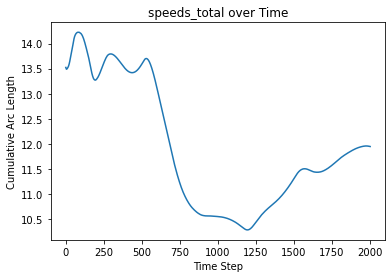

In [12]:
plt.plot(np.arange(len(speeds_total)), speeds_total)
plt.xlabel('Time Step')
plt.ylabel('Cumulative Arc Length')
plt.title('speeds_total over Time')
plt.show()

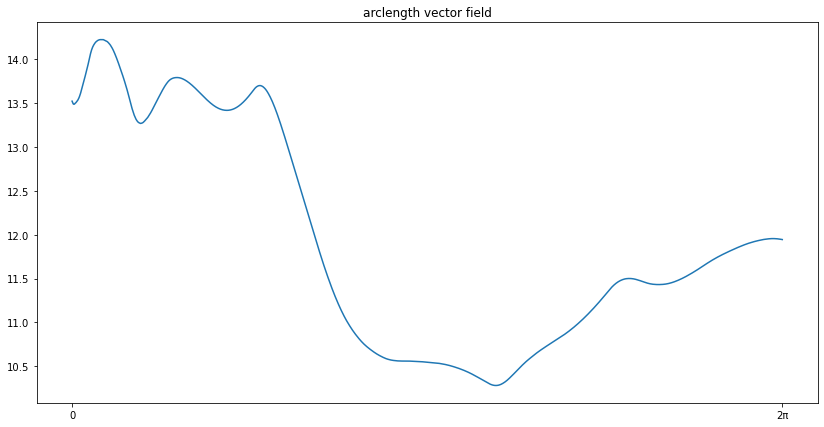

In [13]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,7)
period_speeds = speeds_total
period_speeds_x = [i * 2 * math.pi / len(period_speeds) for i in range(len(period_speeds))]  # to plot only '0' and '2pi'
plt.plot(period_speeds_x, period_speeds)
plt.title("arclength vector field")
plt.xticks([0, 6.28], ['0', '2π'], rotation='horizontal')
plt.show()


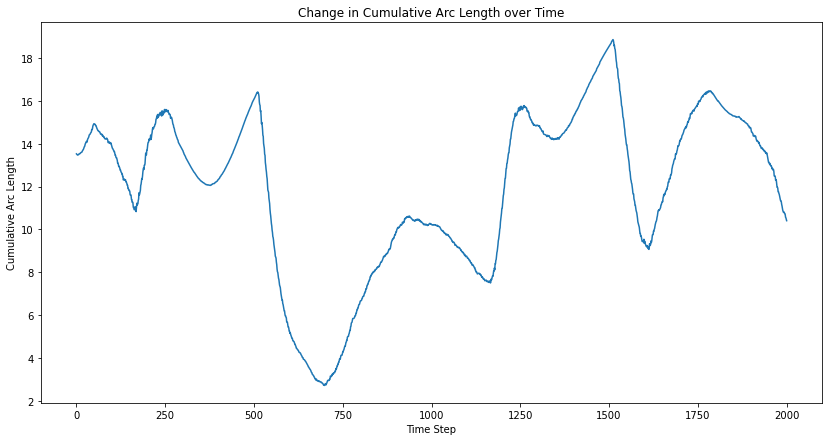

In [14]:
plt.plot(np.arange(len(speeds_ins)), speeds_ins)
plt.xlabel('Time Step')
plt.ylabel('Cumulative Arc Length')
plt.title('Change in Cumulative Arc Length over Time')
plt.show()

Part 4: predict the utilization of the MI building for 14 days

In [15]:
# non-linear process on vector field
n_bases = 1000
eps = 100.0
arclens_data = np.expand_dims(np.array(arclens[:len(period_speeds)]), 1)
period_speeds_data = np.expand_dims(np.array(period_speeds), 1)
centers = arclens_data[np.random.choice(range(arclens_data.shape[0]), replace=False, size=1000)]
C, res, _, _, _, eps, phi = approx_nonlin_func(data=(arclens_data,period_speeds_data), n_bases=n_bases, eps=eps, centers=centers)

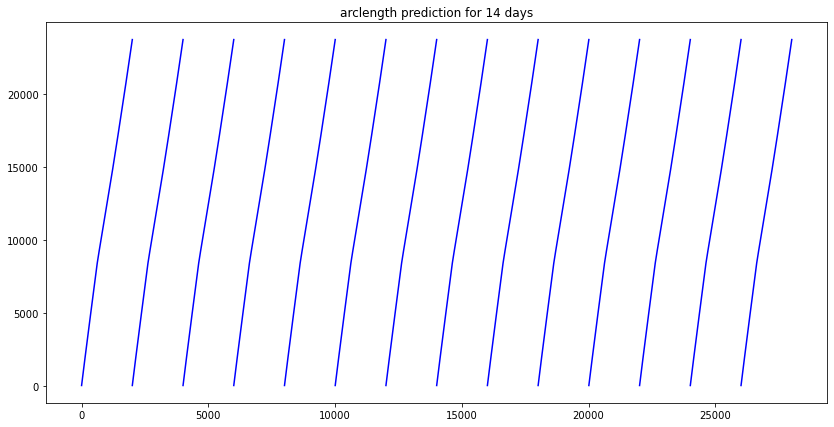

In [16]:
# estimate the arclength for 14 days
starting_point = arclens_data[0]
arclens_14 = []
end_time = len(period_speeds) * 14  # each period is one day
for i in range(end_time // len(period_speeds)):
    t_eval = np.linspace(0, len(period_speeds), len(period_speeds))
    sol = solve_ivp(rbf_approx, [0, len(period_speeds)], starting_point, t_eval=t_eval, args=[centers, eps, C])
    sol.t = sol.t + i * len(period_speeds)
    arclens_14.append(sol.y[0, :])
    plt.plot(sol.t, sol.y[0, :],color='blue')
plt.title("arclength prediction for 14 days")
arclens_14 = np.expand_dims(np.array(arclens_14).flatten(), 1)
plt.show()

In [17]:
# mapping each arclength to a first area measurement
arclens_cut = arclens_14[:data_after1000.shape[0]]
area1 = data_after1000[:, 1]
area1 = np.expand_dims(np.array(area1[:len(area1)]), 1)

n_bases = 1000
eps = 100
centers = arclens_cut[np.random.choice(range(arclens_cut.shape[0]), replace=False, size=n_bases)]
C, res, _, _, _, eps, phi = approx_nonlin_func(data=(arclens_cut, area1), n_bases=n_bases, eps=eps,
                                               centers=centers)

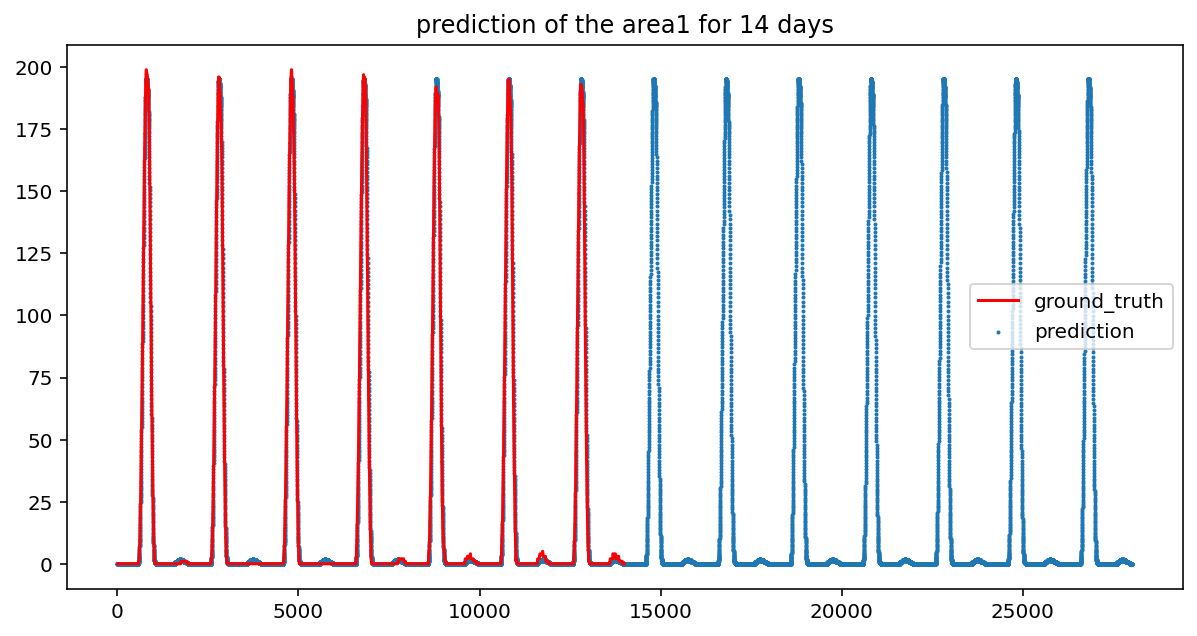

In [26]:
# visualize the result of prediction
plt.rcParams["figure.figsize"] = (10,5)
phis = []
for i in range(len(arclens_14)):
    prova = np.expand_dims(arclens_14[i], 1)
    single_phi = rbf(prova, centers, eps)
    phis.append(single_phi@C)
plt.scatter(range(len(arclens_14)), phis, s=1, label='prediction')
plt.plot(area1, c='red', label='ground_truth')
plt.title("prediction of the area1 for 14 days")
plt.legend()
plt.show()